In [3]:
import numpy as np
import torch
import functools
import time
import matplotlib.pyplot as plt

In [35]:
def poly(*a):
    """
    :param a: a list of coefficients starting with the coefficient of the highest degree down to 0.
    :return: same as numpy.poly1d(a)
    """
    return np.poly1d(a)

def NOISY(noise):
    def decorate(function):
        def wrapper(*args, **kwargs):
            result = function(*args, **kwargs)
            result+=np.random.randn()*noise
            return result
        return wrapper
    return decorate

In [36]:
def find_roots(p: np.poly1d, start, end, maxerr=0.001):
    global base_poly_roots_finders
    coefs = p.coefficients
    d = p.order
    if d < len(base_poly_roots_finders):
        return base_poly_roots_finders[d](start, end, *coefs)
    dp_roots = find_roots(np.polyder(p), start, end)
    return find_roots_from_der_roots(p, start, dp_roots, end, maxerr)

def _find_roots_poly_constant(start, end, constant):
    if constant == 0:
        raise Exception("Zero polynomial has infinite amount roots")
    return []
def _find_roots_poly_linear_line(start, end, slope, constant):
    if slope == 0:
        return _find_roots_poly_constant(start, end, constant)
    root = (-constant) / slope
    return _roots_list(start, end, root)
def _find_roots_poly_quadratic(start, end, a, b, c):
    if a == 0:
        return _find_roots_poly_linear_line(start, end, b ,c)
    return _find_roots_poly_quadratic_core(a, b, c, end, start)

def _find_roots_poly_quadratic_core(a, b, c, end, start):
    delta = (b ** 2) - 4 * a * c
    if delta < 0:
        return []
    elif delta == 0:
        root = -b / (2 * a)
        return _roots_list(start, end, root)
    else:
        return _find_roots_poly_quadratic_2_roots(a, b, delta, end, start)

def _find_roots_poly_quadratic_2_roots(a, b, delta, end, start):
    delta = np.sqrt(delta)
    root0 = (-b + delta) / (2 * a)
    root1 = (-b - delta) / (2 * a)
    root0, root1 = min(root0, root1), max(root0, root1)
    return _roots_list(end, start, root0, root1)


base_poly_roots_finders = [
    _find_roots_poly_constant,
    _find_roots_poly_linear_line,
    _find_roots_poly_quadratic
]

def _roots_list(end, start, *roots):
    return [root for root in roots if start <= root <= end]

def find_poly_roots(p, a, dp_roots, b, maxerr):
    roots = []

    prev_a = a
    p_prev_a = p(a)
    if is_root(p_prev_a, maxerr):
        roots.append(prev_a)

    for i in range(len(dp_roots)):
        dpr = dp_roots[i]
        p_dpr = p(dpr)
        if is_root(p_dpr, maxerr):
            roots.append(dpr)
        elif (p_prev_a < 0) != (p_dpr < 0):
            roots.append(regula_falsi(p, prev_a, dpr, maxerr))
        else:
            pass
        prev_a = dpr
        p_prev_a = p_dpr

    p_b = p(b)
    if is_root(p_b, maxerr):
        roots.append(b)
    elif (p_prev_a < 0) != (p_b < 0):
        roots.append(regula_falsi(p, prev_a, b, maxerr))
    else:
        pass
    return roots

def is_root(y, maxerr):
    return abs(y) <= maxerr

def regula_falsi(f, a, b, maxerr):
    c = b
    fc = fb = f(b)
    while not is_root(fc, maxerr):
        c = b - fb * ((b - a) / (fb - f(a)))
        fc = f(c)
        if (fc < 0) != (fb < 0):
            a = c
        else:
            b = c
            fb = fc
    return c


def poly_to_string(p):
    coefficients = p.coefficients
    highest = coefficients[0]
    n = len(coefficients) - 1

    s = ""
    if highest == -1:
        s += "-"
    elif highest == 1:
        pass
    else:
        s += str(highest)
    if n >= 10:
        s += f"x^({n})"
    elif n > 1:
        s += f"x^{n}"
    elif n == 1:
        s += "x"
    for k in range(1, n - 1):
        coef = coefficients[k]
        if coef == 0:
            continue
        s += " "
        if coef < 0:
            s += "-"
        else:
            s += "+"
        s += " "
        if abs(coef) != 1:
            s += str(abs(coef))
        s += f"x^{n-k}"
    if n > 1:
        coef = coefficients[n - 1]
        if coef != 0:
            s += " "
            if coef < 0:
                s += "-"
            else:
                s += "+"
            s += " "
            if abs(coef) != 1:
                s += str(abs(coef))
            s += f"x"
    if n > 0:
        coef = coefficients[n]
        if coef != 0:
            s += " "
            if coef < 0:
                s += "-"
            else:
                s += "+"
            s += " "
            if abs(coef) != 1:
                s += str(abs(coef))
    return s

In [37]:
M3 = torch.Tensor(
            [[-1, +3, -3, +1],
             [+3, -6, +3, 0],
             [-3, +3, 0, 0],
             [+1, 0, 0, 0]]
        )

def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt(((x1 - x2) ** 2) + ((y1 - y2) ** 2))

def fit(f: callable, a: float, b: float, d:int, maxtime: float) -> callable:
    """
    Build a function that accurately fits the noisy data points sampled from
    some closed shape. 

    Parameters
    ----------
    f : callable. 
        A function which returns an approximate (noisy) Y value given X. 
    a: float
        Start of the fitting range
    b: float
        End of the fitting range
    d: int 
        The expected degree of a polynomial matching f
    maxtime : float
        This function returns after at most maxtime seconds. 

    Returns
    -------
    a function:float->float that fits f between a and b
    """
    n = 1000
    Md = M3

    time_took = time.time()
    fit_func = fit_core(f, a, b, d, n, Md)
    time_took = time.time() - time_took

    time_left = maxtime - time_took - 0.01
    n = (time_left / (time_took * 2 + 0.005)) * 1000
    n = int(min(round((b - a) * 5000), n))
    if n >= 2000:
        fit_func = fit_core(f, a, b, n, d, Md)
    return fit_func

def fit_core(f: callable, a: float, b: float, d: int, n: int, Md):
    x_samples = np.concatenate([[a], (np.random.random(n - 2) * (b - a)) + a, [b]])
    x_samples.sort()
    y_samples = f(x_samples)
    P = torch.stack([torch.Tensor(x_samples), torch.Tensor(y_samples)]).T

    dis = [0] * n
    def sum_d(acc, i):
        d = acc + euclidean_distance(x_samples[i], y_samples[i], x_samples[i - 1], y_samples[i - 1])
        dis[i] = d
        return d
    d_total = functools.reduce(sum_d, range(1, n), 0)

    t = torch.Tensor([dis[i] / d_total for i in range(n)])
    T = torch.stack([t ** k for k in range(3, -1, -1)]).T
    C = Md.inverse().mm((T.T.mm(T)).inverse()).mm(T.T).mm(P)
    bezier_curve = Md.mm(C).T
    bezier_x_poly = np.poly1d(bezier_curve[0])
    bezier_y_poly = np.poly1d(bezier_curve[1])

    def fit_func(x):
        if x == a:
            return bezier_y_poly(0)
        if x == b:
            return bezier_y_poly(1)
        ts = poly_funcs.find_roots(bezier_x_poly - x, -0.5, 1.5)
        if len(ts) == 0:
            raise Exception(f"No t matching x={x}")
        return bezier_y_poly(ts[0])

    return fit_func, bezier_curve, bezier_x_poly, bezier_y_poly, T, C, P

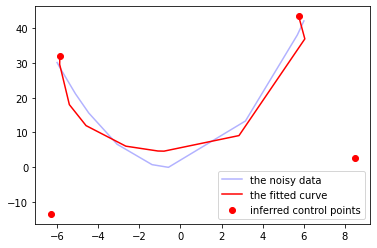

In [38]:
f = NOISY(1)(poly(1, 1, 1))
t_s = time.time()
fit_func, bezier_curve, bezier_x_poly, bezier_y_poly, T, C, P = fit(f=f, a=-6, b=6, d=10, maxtime=5)
t_s = time.time() - t_s
#print(f"time: {t_s}")
#print(C.T)

#get the new curve
pts = T.mm(M3).mm(C).T

plt.plot(P.T[0],P.T[1],alpha=0.3, color="blue", label="the noisy data")
plt.scatter(C.T[0],C.T[1], color="red", label="inferred control points")
plt.plot(pts[0], pts[1], color="red", label="the fitted curve")
plt.legend()
plt.show()

In [44]:
def find_t(x, a, b, ts):
    estimated_t = (x - a) / (b - a)
    t = min(ts, key=lambda x: abs(x - estimated_t))
    return t
print(find_t(1, 0, 1, [-0.3323953055214343, 0.498023646031114, 1.1550876511811676]))

1.1550876511811676
